In [1]:
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [3]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

22/10/08 11:22:33 WARN Utils: Your hostname, Runyus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.12 instead (on interface en0)
22/10/08 11:22:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 11:22:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
trans_sdf = read_file(spark, 'changed_data', '../data/curated/')

|> Loading File...


|> Loading Finished!
22/10/08 11:22:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
-RECORD 0---------------------------------------------------------------------------------------------
 POA_CODE21        | 2040                                                                             
 user_id           | 11893                                                                            
 merchant_abn      | 90578415511                                                                      
 dollar_value      | 131.14483377730215                                                               
 order_id          | 1db43d10-b5f2-4afc-b94a-948cfa1879f1                                             
 merchant_name     | A Scelerisque Foundation                                                         
 tags              | furniture, home furnishings and equipment shops, and manu

In [5]:
consumer_fraud_sdf = read_file(spark,'consumer_fraud_probability.csv', '../data/tables/', 'csv')

|> Loading File...
|> Loading Finished!
-RECORD 0-----------------------------
 user_id           | 6228             
 order_datetime    | 2021-12-19       
 fraud_probability | 97.6298077657765 
only showing top 1 row



In [6]:
consumer_fraud_sdf.show(5)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
+-------+--------------+-----------------+
only showing top 5 rows



In [7]:
trans_sdf.show(5)

+----------+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+--------+-----------+----------------+-------------------+-----+------+-----------------+---------------+----------+------------+-----------------+------------------+------------------+-----------+---------+--------+---------------+--------------+
|POA_CODE21|user_id|merchant_abn|      dollar_value|            order_id|       merchant_name|                tags|take_rate|type|postcode|consumer_id|            name|            address|state|gender|       population|New cases / day|     month|total_retail|__index_level_0__|          latitude|         longitude|genderIndex|typeIndex|tagIndex|        tag_vec|order_datetime|
+----------+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+--------+-----------+----------------+-------------------+-----+------+-----------------+---------------+---------

In [8]:
sdf = trans_sdf.select( 'user_id', 'merchant_abn', 'order_datetime', 'dollar_value', 'take_rate', 'consumer_id', 'POA_CODE21', 'longitude', 'latitude', 'genderIndex', 'typeIndex', 'tagIndex', 'tag_vec')

In [9]:
sdf.show(5)

+-------+------------+--------------+------------------+---------+-----------+----------+------------------+------------------+-----------+---------+--------+---------------+
|user_id|merchant_abn|order_datetime|      dollar_value|take_rate|consumer_id|POA_CODE21|         longitude|          latitude|genderIndex|typeIndex|tagIndex|        tag_vec|
+-------+------------+--------------+------------------+---------+-----------+----------+------------------+------------------+-----------+---------+--------+---------------+
|  11893| 90578415511|    2021-11-26|131.14483377730215|     5.95|     245147|      2040|-33.87722582700607|151.15759301879152|        1.0|      0.0|    10.0|(24,[10],[1.0])|
|   9174| 64203420245|    2021-11-26|42.647866295122945|     2.86|    1392834|      2000| -33.8683837718929| 151.2082196508253|        0.0|      2.0|     0.0| (24,[0],[1.0])|
|  12642| 21439773999|    2021-11-26| 40.05069328365354|      6.1|     331077|      5556|-33.89344361937781|137.6678136093520

Feature Attributes

In [10]:
import pyspark.sql.functions as F

In [90]:
from pyspark.sql.functions import datediff


sdf_merchant_and_consumer = sdf_merchant = sdf.groupby('merchant_abn', 'user_id').agg(
    F.count("*").alias('purchase_frequency'),
    F.avg('dollar_value').alias('average_consumer_purchase'),
    datediff(F.max('order_datetime'),F.min('order_datetime')).alias('purchase_duration'),
    (datediff(F.max('order_datetime'),F.min('order_datetime'))/F.count("*")).alias('avg_purchase_duration')
)

In [12]:
sdf_merchant_and_consumer

merchant_abn,user_id,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration
45572698303,6360,1,211.5632373274013,0,0.0
48256546416,16411,1,150.18536278862666,0,0.0
46804135891,16404,3,47.82492906555759,57,19.0
51550230865,22640,1,85.78778125865814,0,0.0
57900494384,18403,5,17.27036737561085,0,0.0
62224020443,18854,1,72.79652611412729,0,0.0
96146457679,23137,1,23.493416071205736,0,0.0
47086412084,9744,2,13.529218880420904,11,5.5
41216931608,11435,1,28.30405819414037,0,0.0
42355028515,5714,1,93.93823030529252,0,0.0


In [13]:
sdf_daily = sdf.groupby('merchant_abn','user_id', 'order_datetime', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec').agg(
    F.count("*").alias("count"), 
    F.avg("dollar_value").alias("dollar_average"),
    F.min("dollar_value").alias("dollar_min"),
    F.max("dollar_value").alias("dollar_max"),
    )

In [14]:
sdf_daily

merchant_abn,user_id,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max
89932674734,13070,2021-11-26,1.67,2.0,9.0,"(24,[9],[1.0])",2,542.5953740463158,542.5953740463158,542.5953740463158
67882460777,16079,2021-11-26,5.91,0.0,7.0,"(24,[7],[1.0])",1,124.97000684460642,124.97000684460642,124.97000684460642
49891706470,1579,2021-11-26,5.8,0.0,0.0,"(24,[0],[1.0])",1,23.954974549902467,23.954974549902467,23.954974549902467
47086412084,16164,2021-11-26,2.52,2.0,2.0,"(24,[2],[1.0])",1,1.5456824995258296,1.5456824995258296,1.5456824995258296
67400260923,11958,2021-11-26,5.97,0.0,8.0,"(24,[8],[1.0])",1,96.94182735381395,96.94182735381395,96.94182735381395
76314317957,11958,2021-11-26,5.93,0.0,5.0,"(24,[5],[1.0])",1,159.00242716710244,159.00242716710244,159.00242716710244
28208763477,13984,2021-11-26,2.04,2.0,3.0,"(24,[3],[1.0])",1,130.55140268747957,130.55140268747957,130.55140268747957
16570599421,12371,2021-11-26,6.74,0.0,2.0,"(24,[2],[1.0])",2,119.72224715795643,119.72224715795643,119.72224715795643
24852446429,1670,2021-11-26,2.94,2.0,5.0,"(24,[5],[1.0])",1,17.884225486004613,17.884225486004613,17.884225486004613
41974958954,13314,2021-11-26,5.51,0.0,4.0,"(24,[4],[1.0])",1,59.572038969078086,59.572038969078086,59.572038969078086


In [15]:
sdf_daily = sdf_daily.join(sdf_merchant_and_consumer, on = ['user_id', 'merchant_abn'], how = 'left')

In [16]:
sdf_daily

user_id,merchant_abn,order_datetime,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration
15990,14336275166,2021-11-26,0.67,3.0,0.0,"(24,[0],[1.0])",1,671.3169353142887,671.3169353142887,671.3169353142887,1,671.3169353142887,0,0.0
3480,14430838529,2021-11-26,2.03,2.0,4.0,"(24,[4],[1.0])",1,55.51102590837429,55.51102590837429,55.51102590837429,1,55.51102590837429,0,0.0
18987,15560455575,2021-11-26,4.08,1.0,2.0,"(24,[2],[1.0])",1,113.61685089595571,113.61685089595571,113.61685089595571,1,113.61685089595571,0,0.0
12371,16570599421,2021-11-26,6.74,0.0,2.0,"(24,[2],[1.0])",2,119.72224715795643,119.72224715795643,119.72224715795643,2,119.72224715795643,0,0.0
17527,24852446429,2021-11-26,2.94,2.0,5.0,"(24,[5],[1.0])",1,45.56568489738977,45.56568489738977,45.56568489738977,7,28.167431330316457,132,18.857142857142858
14514,28068880408,2021-11-26,3.23,1.0,1.0,"(24,[1],[1.0])",1,65.87864671860459,65.87864671860459,65.87864671860459,1,65.87864671860459,0,0.0
8302,29641342749,2021-11-26,6.43,0.0,8.0,"(24,[8],[1.0])",1,112.48055643028559,112.48055643028559,112.48055643028559,1,112.48055643028559,0,0.0
8124,38435278995,2021-11-26,6.17,0.0,17.0,"(24,[17],[1.0])",2,94.67473699760147,94.67473699760147,94.67473699760147,2,94.67473699760147,0,0.0
22131,38971488186,2021-11-26,3.61,1.0,12.0,"(24,[12],[1.0])",5,97.07532178664165,97.07532178664165,97.07532178664165,5,97.07532178664165,0,0.0
21521,41502716433,2021-11-26,4.81,1.0,15.0,"(24,[15],[1.0])",1,498.50917822272896,498.50917822272896,498.50917822272896,1,498.50917822272896,0,0.0


In [17]:
consumer_fraud_sdf.show

<bound method DataFrame.show of +-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
|  16556|    2022-02-20|89.65663294494827|
|  10278|    2021-09-28|83.59136689427714|
|  15790|    2021-12-30|71.77065889280253|
|   5233|    2021-08-29|85.87123303878818|
|    230|    2021-08-28|86.28328808934151|
|  13601|    2021-12-26|83.13696487489679|
|   6383|    2021-09-15| 66.2676451623754|
|   3513|    2022-02-27|75.16981192247916|
|  18658|    2021-10-19|82.98609082999361|
|   5965|    2021-11-14|69.37164467869053|
|  18714|    2021-11-14|83.78813794627237|
|  22957|    2022-02-12|82.79065699075498|
|  20118|    2021-09-05|80.34030486265003|
|   6436|    2021-12-24|84.81618344606828|
|  17900|    2022-02-2

In [18]:
train_data = sdf_daily.join(consumer_fraud_sdf, on=['user_id', 'order_datetime'], how = 'inner')

In [19]:
trans_data = sdf_daily.join(consumer_fraud_sdf, on=['user_id', 'order_datetime'], how = 'left_outer')

In [20]:
train_data

user_id,order_datetime,merchant_abn,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration,fraud_probability
11888,2021-10-15,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,338.412985820868,338.412985820868,338.412985820868,1,338.412985820868,0,0.0,8.847698811820532
23372,2021-10-28,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,215.76683088563163,215.76683088563163,215.76683088563163,1,215.76683088563163,0,0.0,10.648936958449216
10321,2021-11-28,10142254217,4.22,1.0,4.0,"(24,[4],[1.0])",1,101.3360962444897,101.3360962444897,101.3360962444897,1,101.3360962444897,0,0.0,11.678203292713205
14800,2022-01-19,10192359162,6.33,0.0,14.0,"(24,[14],[1.0])",1,246.59006816068975,246.59006816068975,246.59006816068975,1,246.59006816068975,0,0.0,11.66880207465038
484,2021-09-18,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,10.484362788304363,10.484362788304363,10.484362788304363,3,10.484362788304363,0,0.0,9.596175013191317
2420,2021-11-23,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",12,68.89413806039774,68.89413806039774,68.89413806039774,24,57.15930265018975,58,2.4166666666666665,9.539761079370496
3387,2021-12-19,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,33.12991729114573,33.12991729114573,33.12991729114573,6,30.35888438438671,80,13.333333333333334,9.525165518951825
6196,2022-01-19,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,22.63139291566044,22.63139291566044,22.63139291566044,1,22.63139291566044,0,0.0,35.077870628101024
7716,2021-12-10,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,56.793815773685715,56.793815773685715,56.793815773685715,3,56.793815773685715,0,0.0,17.974982672017752
10843,2021-11-24,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,53.549726641091276,53.549726641091276,53.549726641091276,1,53.549726641091276,0,0.0,13.631566163723924


In [21]:
trans_data

user_id,order_datetime,merchant_abn,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration,fraud_probability
15990,2021-11-26,14336275166,0.67,3.0,0.0,"(24,[0],[1.0])",1,671.3169353142887,671.3169353142887,671.3169353142887,1,671.3169353142887,0,0.0,null
3480,2021-11-26,14430838529,2.03,2.0,4.0,"(24,[4],[1.0])",1,55.51102590837429,55.51102590837429,55.51102590837429,1,55.51102590837429,0,0.0,null
18987,2021-11-26,15560455575,4.08,1.0,2.0,"(24,[2],[1.0])",1,113.61685089595571,113.61685089595571,113.61685089595571,1,113.61685089595571,0,0.0,null
12371,2021-11-26,16570599421,6.74,0.0,2.0,"(24,[2],[1.0])",2,119.72224715795643,119.72224715795643,119.72224715795643,2,119.72224715795643,0,0.0,null
17527,2021-11-26,24852446429,2.94,2.0,5.0,"(24,[5],[1.0])",1,45.56568489738977,45.56568489738977,45.56568489738977,7,28.167431330316457,132,18.857142857142858,null
14514,2021-11-26,28068880408,3.23,1.0,1.0,"(24,[1],[1.0])",1,65.87864671860459,65.87864671860459,65.87864671860459,1,65.87864671860459,0,0.0,null
8302,2021-11-26,29641342749,6.43,0.0,8.0,"(24,[8],[1.0])",1,112.48055643028559,112.48055643028559,112.48055643028559,1,112.48055643028559,0,0.0,null
8124,2021-11-26,38435278995,6.17,0.0,17.0,"(24,[17],[1.0])",2,94.67473699760147,94.67473699760147,94.67473699760147,2,94.67473699760147,0,0.0,null
22131,2021-11-26,38971488186,3.61,1.0,12.0,"(24,[12],[1.0])",5,97.07532178664165,97.07532178664165,97.07532178664165,5,97.07532178664165,0,0.0,null
21521,2021-11-26,41502716433,4.81,1.0,15.0,"(24,[15],[1.0])",1,498.50917822272896,498.50917822272896,498.50917822272896,1,498.50917822272896,0,0.0,null


In [22]:
from pyspark.sql.functions import year, month, dayofmonth

In [23]:
train_fraud_table = (train_data
               .withColumn('order_year', year(train_data.order_datetime))
               .withColumn('order_month', month(train_data.order_datetime))
               .withColumn('order_day', dayofmonth(train_data.order_datetime))
               )

In [24]:
train_fraud_table = train_fraud_table.drop('order_datetime')

In [25]:
train_fraud_table.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration| fraud_probability|order_year|order_month|order_day|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+
|  11888| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|  338.412985820868|  338.412985820868|  338.412985820868|                 1|         338.412985820868|                0|   

In [27]:
train_fraud_table = (train_fraud_table
                     .withColumn('fraud_probability', train_fraud_table['fraud_probability'].cast('double'))
                     )

- Test Data

In [28]:
test_fraud_table = (trans_data
               .withColumn('order_year', year(train_data.order_datetime))
               .withColumn('order_month', month(train_data.order_datetime))
               .withColumn('order_day', dayofmonth(train_data.order_datetime))
               )

In [29]:
train_fraud_table = (train_fraud_table
                     .withColumn('fraud_probability', train_fraud_table['fraud_probability'].cast('double'))
                     )

In [30]:
test_fraud_table = test_fraud_table.drop('order_datetime','fraud_probability')

In [31]:
test_fraud_table.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+
|  18987| 15560455575|     4.08|      1.0|     2.0| (24,[2],[1.0])|    1|113.61685089595571|113.61685089595571|113.61685089595571|                 1|       113.61685089595571|                0|                  0.0|      2021|         11|       26|
|   

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
train_corr = train_fraud_table.toPandas()

In [93]:
columns = ['user_id', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec', 'count', 'dollar_average', 'dollar_min', 'dollar_max','purchase_frequency','average_consumer_purchase','purchase_duration','avg_purchase_duration', 'order_year', 'order_month', 'order_day', 'fraud_probability']
corr = train_corr[columns].corr(method='spearman')

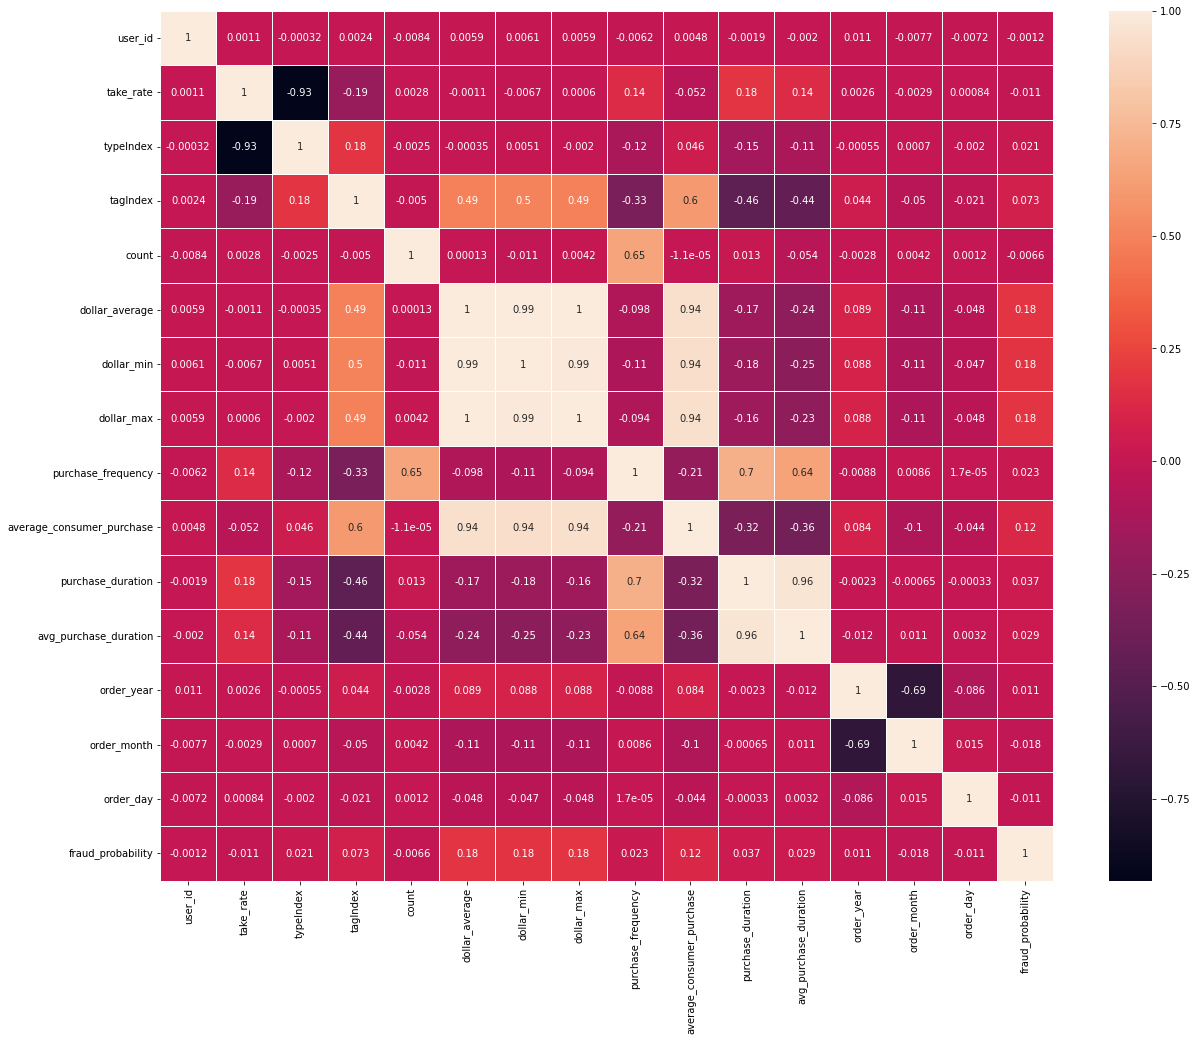

In [94]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(corr,annot = True, linewidths=1)
plt.show()

In [32]:
from pyspark.ml.feature import VectorAssembler

In [33]:
input_col = ['user_id', 'take_rate', 'typeIndex', 'tagIndex', 'tag_vec', 'count', 'dollar_average', 'dollar_min', 'dollar_max','purchase_frequency','average_consumer_purchase','purchase_duration','avg_purchase_duration', 'order_year', 'order_month', 'order_day', 'fraud_probability']

In [34]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [35]:
train_dataset = vecAssembler.transform(train_fraud_table)

In [36]:
train_dataset

user_id,merchant_abn,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration,fraud_probability,order_year,order_month,order_day,features
11888,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,338.412985820868,338.412985820868,338.412985820868,1,338.412985820868,0,0.0,8.847698811820532,2021,10,15,"(40,[0,1,2,3,14,2..."
23372,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,215.76683088563163,215.76683088563163,215.76683088563163,1,215.76683088563163,0,0.0,10.648936958449216,2021,10,28,"(40,[0,1,2,3,14,2..."
10321,10142254217,4.22,1.0,4.0,"(24,[4],[1.0])",1,101.3360962444897,101.3360962444897,101.3360962444897,1,101.3360962444897,0,0.0,11.678203292713205,2021,11,28,"(40,[0,1,2,3,8,28..."
14800,10192359162,6.33,0.0,14.0,"(24,[14],[1.0])",1,246.59006816068975,246.59006816068975,246.59006816068975,1,246.59006816068975,0,0.0,11.66880207465038,2022,1,19,"(40,[0,1,3,18,28,..."
484,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,10.484362788304363,10.484362788304363,10.484362788304363,3,10.484362788304363,0,0.0,9.596175013191317,2021,9,18,"(40,[0,1,3,5,28,2..."
2420,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",12,68.89413806039774,68.89413806039774,68.89413806039774,24,57.15930265018975,58,2.4166666666666665,9.539761079370496,2021,11,23,"(40,[0,1,3,5,28,2..."
3387,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,33.12991729114573,33.12991729114573,33.12991729114573,6,30.35888438438671,80,13.333333333333334,9.525165518951825,2021,12,19,"(40,[0,1,3,5,28,2..."
6196,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,22.63139291566044,22.63139291566044,22.63139291566044,1,22.63139291566044,0,0.0,35.077870628101024,2022,1,19,"(40,[0,1,3,5,28,2..."
7716,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,56.793815773685715,56.793815773685715,56.793815773685715,3,56.793815773685715,0,0.0,17.974982672017752,2021,12,10,"(40,[0,1,3,5,28,2..."
10843,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,53.549726641091276,53.549726641091276,53.549726641091276,1,53.549726641091276,0,0.0,13.631566163723924,2021,11,24,"(40,[0,1,3,5,28,2..."


- Feature correlation and covariance

In [37]:
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
r1 = Correlation.corr(train_dataset, "features")
r1_head = r1.head()
# 皮尔森（pearson）相关系数

print(r1)
print("Pearson correlation matrix:\n" + str(r1_head[0]))
print("-------------------------------------------------------------------------")
# 斯皮尔曼（spearman）相关系数
r2 = Correlation.corr(train_dataset, "features", "spearman")
r2_head = r2.head()
print("Spearman correlation matrix:\n" + str(r2_head[0]))


+--------------------+
|   pearson(features)|
+--------------------+
|1.0              ...|
+--------------------+

Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  6.03566076e-04, -3.34632237e-04, ...,
              -1.01461329e-02, -7.43236586e-03, -5.85338755e-03],
             [ 6.03566076e-04,  1.00000000e+00, -9.48907814e-01, ...,
              -1.99175024e-03,  3.66593229e-04, -1.81383171e-03],
             [-3.34632237e-04, -9.48907814e-01,  1.00000000e+00, ...,
               8.29247423e-04, -8.58897692e-04,  1.24357292e-02],
             ...,
             [-1.01461329e-02, -1.99175024e-03,  8.29247423e-04, ...,
               1.00000000e+00,  6.15936781e-02, -1.22204964e-02],
             [-7.43236586e-03,  3.66593229e-04, -8.58897692e-04, ...,
               6.15936781e-02,  1.00000000e+00,  1.10024060e-03],
             [-5.85338755e-03, -1.81383171e-03,  1.24357292e-02, ...,
              -1.22204964e-02,  1.10024060e-03,  1.00000000e+00]])
---------------------

22/10/08 11:32:32 WARN Executor: Managed memory leak detected; size = 15731324 bytes, task 0.0 in stage 158.0 (TID 698)


22/10/08 11:32:34 WARN Executor: Managed memory leak detected; size = 15731324 bytes, task 0.0 in stage 171.0 (TID 711)


22/10/08 11:32:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/08 11:32:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
Spearman correlation matrix:
DenseMatrix([[ 1.00000000e+00,  1.09706498e-03, -3.24154857e-04, ...,
              -7.66504590e-03, -7.21179887e-03, -1.15362901e-03],
             [ 1.09706498e-03,  1.00000000e+00, -9.32405875e-01, ...,
              -2.94887453e-03,  8.38023894e-04, -1.10505591e-02],
             [-3.24154857e-04, -9.32405875e-01,  1.00000000e+00, ...,
               7.01085812e-04, -1.96016164e-03,  2.08729081e-02],
             ...,
             [-7.66504590e-03, -2.94887453e-03,  7.01085812e-04, ...,
               1.00000000e+00,  1.48961873e-02, -1.81455812e-02],
             [-7.21179887e-03,  8.38023894e-04, -1.96016164e-03, ...,
               1.48961873e-02,  1.00000000e+00, -1.05293041e-02],
             [-1.15362901e-

In [39]:
dense_matrix = r1.to_pandas_on_spark().iloc[0][0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/sql/dataframe.py:3315: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  FutureWarning,


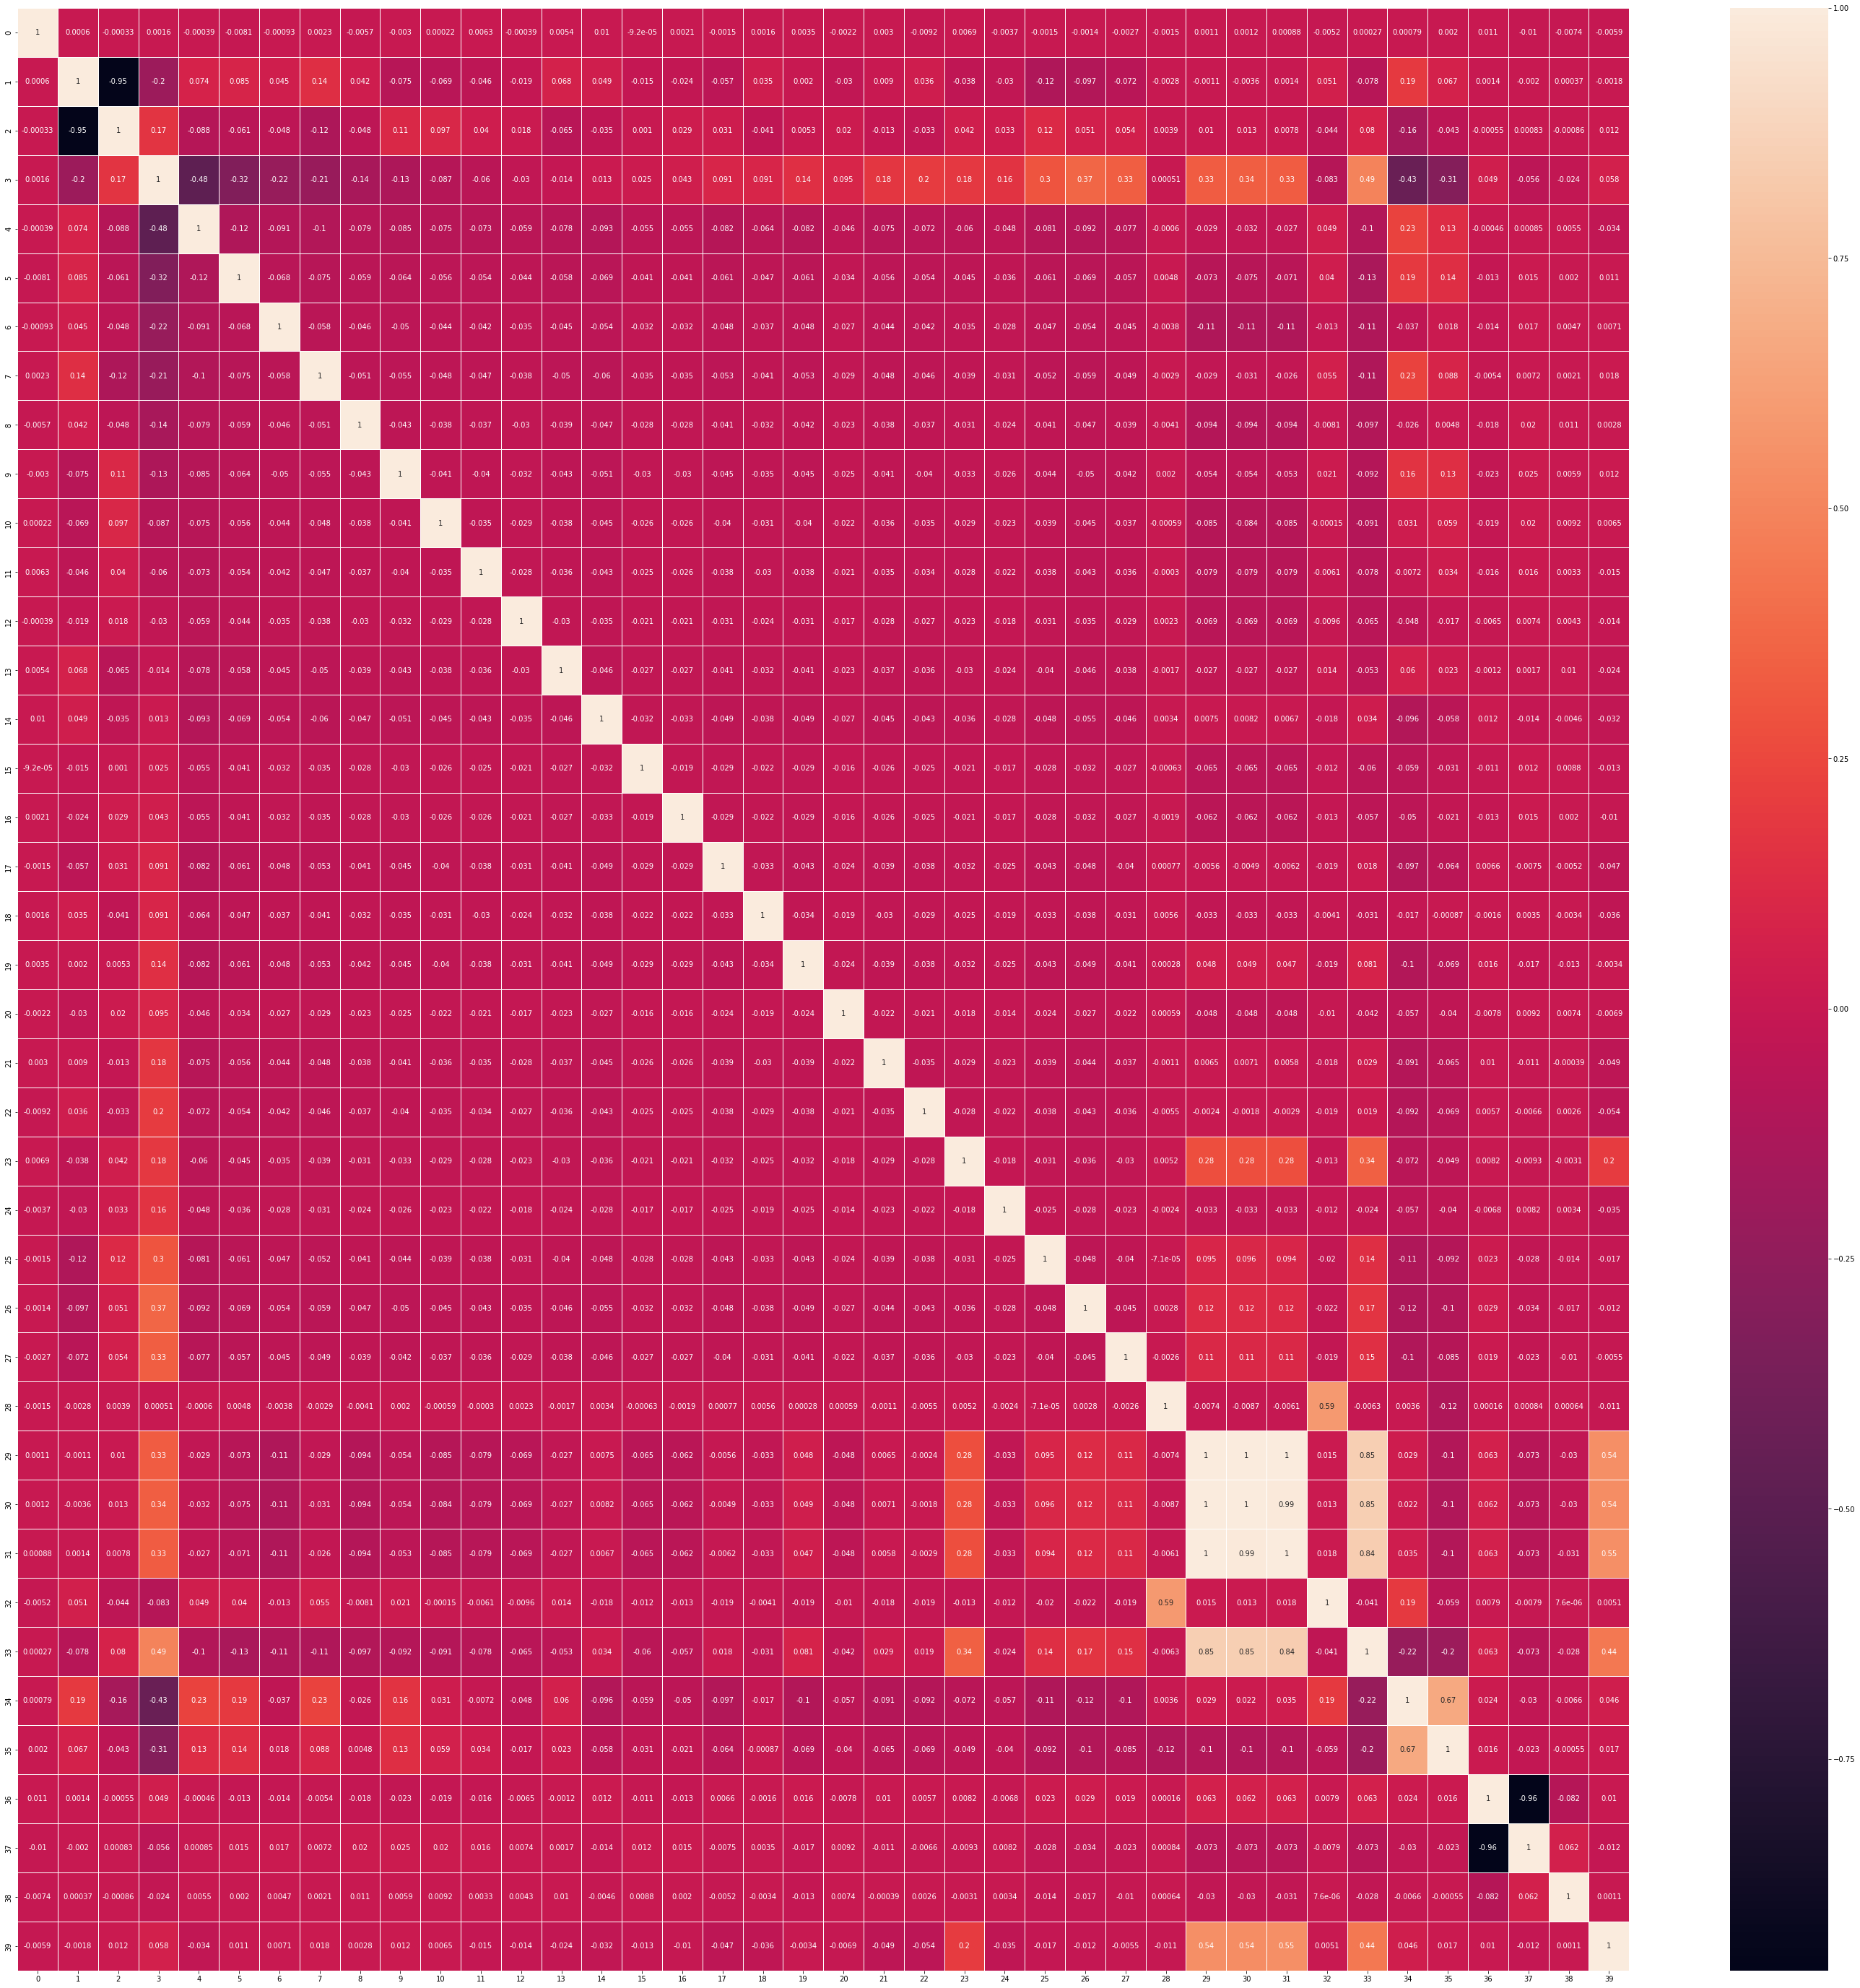

In [40]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(dense_matrix.toArray(),annot = True, linewidths=1)
plt.show()

In [41]:
dense_matrix2 = r2.to_pandas_on_spark().iloc[0][0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/sql/dataframe.py:3315: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  FutureWarning,


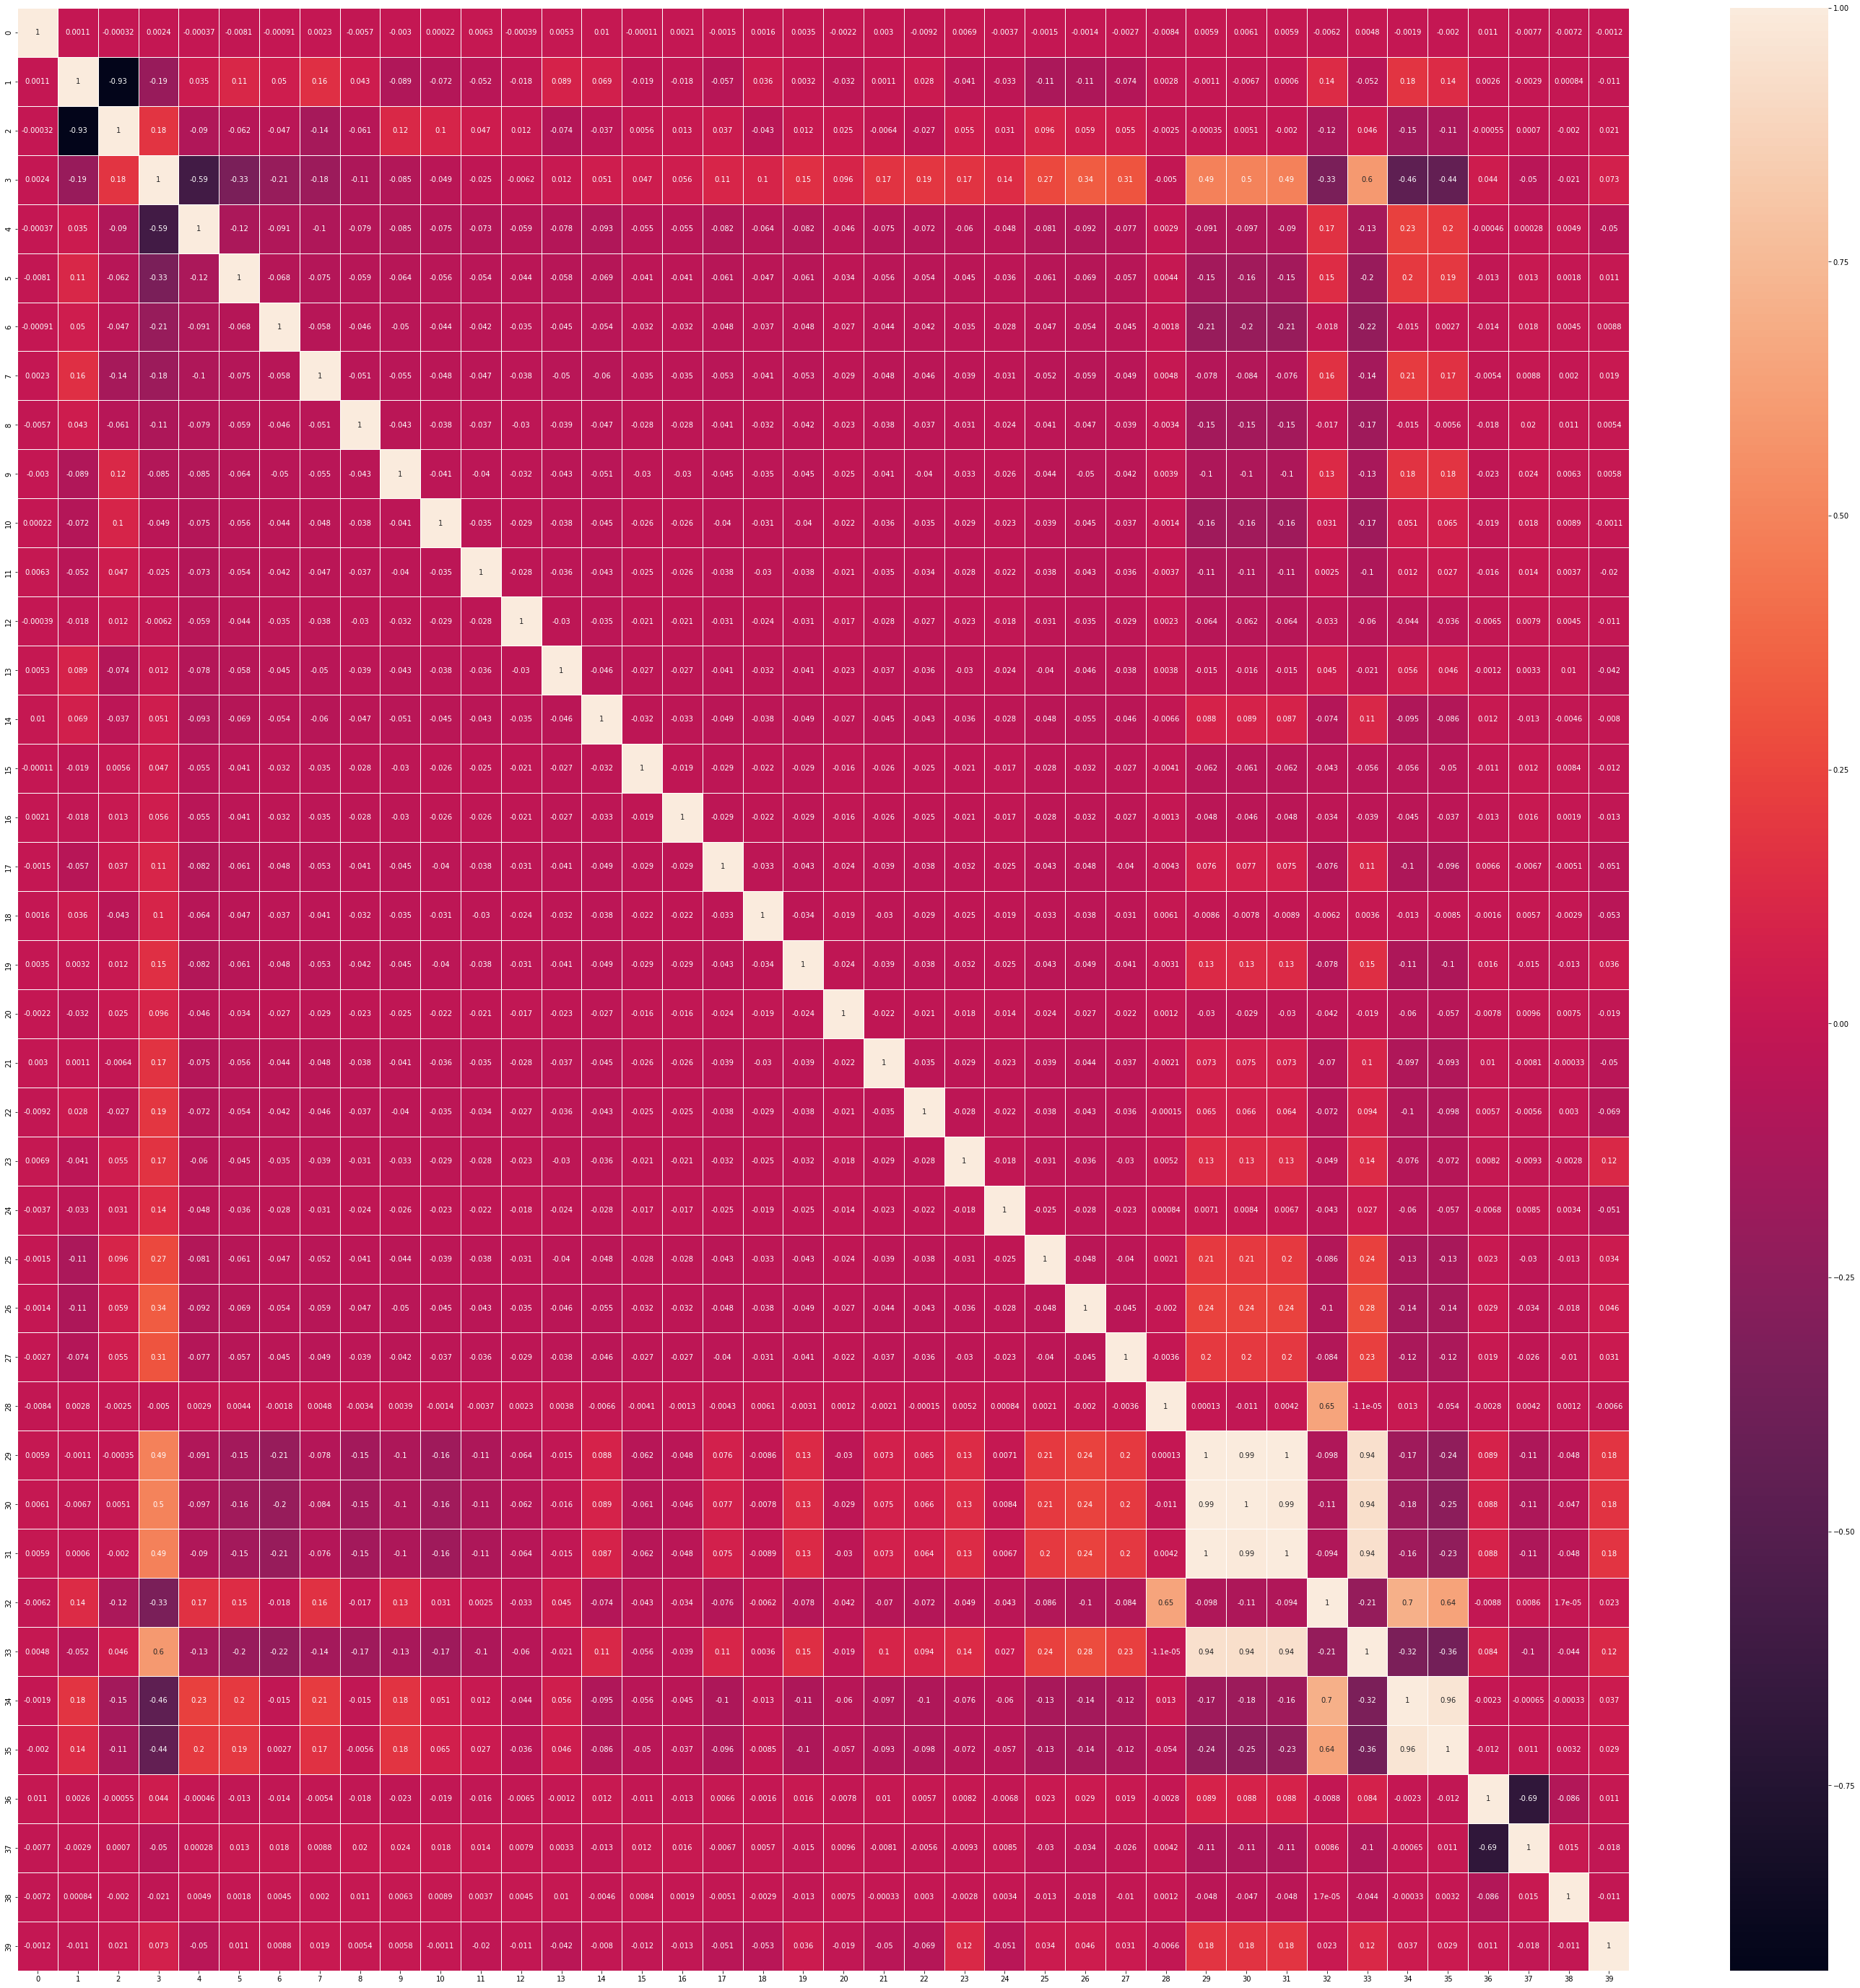

In [42]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(dense_matrix2.toArray(),annot = True, linewidths=1)
plt.savefig('../plots/Feature HeatMap.png')
plt.show()

- Model

In [116]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [126]:
input_col = ['take_rate','tag_vec', 'dollar_average', 'dollar_min', 'dollar_max','purchase_frequency','average_consumer_purchase','purchase_duration','avg_purchase_duration']

In [127]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [128]:
train_dataset = vecAssembler.transform(train_fraud_table)

In [129]:
train_dataset

user_id,merchant_abn,take_rate,typeIndex,tagIndex,tag_vec,count,dollar_average,dollar_min,dollar_max,purchase_frequency,average_consumer_purchase,purchase_duration,avg_purchase_duration,fraud_probability,order_year,order_month,order_day,features
11888,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,338.412985820868,338.412985820868,338.412985820868,1,338.412985820868,0,0.0,8.847698811820532,2021,10,15,"(32,[0,11,25,26,2..."
23372,10023283211,0.18,4.0,10.0,"(24,[10],[1.0])",1,215.76683088563163,215.76683088563163,215.76683088563163,1,215.76683088563163,0,0.0,10.648936958449216,2021,10,28,"(32,[0,11,25,26,2..."
10321,10142254217,4.22,1.0,4.0,"(24,[4],[1.0])",1,101.3360962444897,101.3360962444897,101.3360962444897,1,101.3360962444897,0,0.0,11.678203292713205,2021,11,28,"(32,[0,5,25,26,27..."
14800,10192359162,6.33,0.0,14.0,"(24,[14],[1.0])",1,246.59006816068975,246.59006816068975,246.59006816068975,1,246.59006816068975,0,0.0,11.66880207465038,2022,1,19,"(32,[0,15,25,26,2..."
484,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,10.484362788304363,10.484362788304363,10.484362788304363,3,10.484362788304363,0,0.0,9.596175013191317,2021,9,18,"(32,[0,2,25,26,27..."
2420,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",12,68.89413806039774,68.89413806039774,68.89413806039774,24,57.15930265018975,58,2.4166666666666665,9.539761079370496,2021,11,23,"(32,[0,2,25,26,27..."
3387,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,33.12991729114573,33.12991729114573,33.12991729114573,6,30.35888438438671,80,13.333333333333334,9.525165518951825,2021,12,19,"(32,[0,2,25,26,27..."
6196,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,22.63139291566044,22.63139291566044,22.63139291566044,1,22.63139291566044,0,0.0,35.077870628101024,2022,1,19,"(32,[0,2,25,26,27..."
7716,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",3,56.793815773685715,56.793815773685715,56.793815773685715,3,56.793815773685715,0,0.0,17.974982672017752,2021,12,10,"(32,[0,2,25,26,27..."
10843,10206519221,6.34,0.0,1.0,"(24,[1],[1.0])",1,53.549726641091276,53.549726641091276,53.549726641091276,1,53.549726641091276,0,0.0,13.631566163723924,2021,11,24,"(32,[0,2,25,26,27..."


In [148]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

- LinearRegression Model

In [151]:
lr = LinearRegression(featuresCol='features',labelCol='label', maxIter=5, solver="normal")
lr_model=lr.fit(train_dataset)

22/10/08 21:29:25 WARN Instrumentation: [081e65be] regParam is zero, which might cause numerical instability and overfitting.


In [152]:
print("Correlation coefficient:{}".format(lr_model.coefficients))
print("Intercept:{}".format(lr_model.intercept))

Correlation coefficient:[-0.06952893883152317,-2.3989526320114503,-0.24109955767616165,0.6606867122864509,-0.36234060857885036,0.49364440713705093,-0.14091283028371374,0.5041267520378356,-0.7728181931290365,-0.7037184822412414,-2.408624978033895,-3.8590943539586515,-0.609402990189957,-0.5962102930862884,-4.484105269823763,-3.2971537368914765,-3.8346192173246827,-0.6065555290332423,-5.052771998297513,-5.15292832319154,0.303845232248733,-3.6817156427168687,-5.83520308112059,-5.786342995588034,-5.778167990727445,0.001273819871828019,-0.0007553615727504036,0.0011733084407272263,0.0004946647797125812,-9.430473413774931e-05,-0.019104812652646342,0.08301744207572717]
Intercept:14.415396461222816


In [153]:
training_predictions=lr_model.evaluate(train_dataset) 

In [154]:
print('{}{}'.format('Mean Square Error:',training_predictions.meanSquaredError))
print('{}{}'.format('R2 determination factor：',training_predictions.r2 ))

Mean Square Error:62.5513623851519
R2 determination factor：0.35183090498712644


In [155]:
test_feature = vecAssembler.transform(test_fraud_table)

In [156]:
test_feature.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|            features|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+
|    286| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|132.59732196566966|132.59732196566966|132.59732196566966|                 1|       132.59732196566966|               

In [157]:
test_pred = lr_model.transform(test_feature)

In [158]:
test_pred.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|            features|        prediction|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|    286| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|132.59732196566966|132.59732196566966|132.59732196566966|   

In [159]:
test_pred = test_pred.withColumnRenamed('prediction', 'fraud_probability')

In [160]:
test_pred.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|            features| fraud_probability|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|    286| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|132.59732196566966|132.59732196566966|132.59732196566966|   

In [161]:
test_pred.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|     143.3617235167414|
+----------------------+



In [162]:
test_pred.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|     5.673400458540549|
+----------------------+



In [163]:
test_pred.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|    13.227070486829122|
+----------------------+



- GLM Model

In [164]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

In [165]:
from pyspark.ml.regression import GeneralizedLinearRegression

In [166]:
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
 
# Fit the model
model = glr.fit(train_dataset)
 
# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
 
# Summarize the model over the training set and print out some metrics
summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()


Coefficients: [-0.07397276260343391,-0.8964289795953557,1.2283330730299933,2.1473025298028268,1.0927211436435758,1.976736050116119,1.2921883851961193,1.951871497933289,0.7290377121804743,0.813536686115148,-0.9013034466580844,-2.314621034448967,0.909914600637843,0.9169250775746068,-2.9156047913244074,-1.741326417564917,-2.3166194944027847,0.9018266455803553,-3.4751476050821695,-3.563850941298513,1.4893510060954116,-2.103536552536009,-4.298596848387015,-4.256620654494836,-4.252470983027762,0.0005392783310909466,0.00030351460570252753,0.00076821838159139,0.0003440062611693848,2.487413356290934e-05,-0.01462108509712388,0.07019673377232732]
Intercept: 12.884381533796299


Coefficient Standard Errors: [0.018051066083967487, 0.16731430927354907, 0.1824266389055131, 0.19820037171929655, 0.19359897497329193, 0.21113159027310666, 0.2043770753372882, 0.21569129469916773, 0.21888299448172607, 0.24687842683555022, 0.21092882002691743, 0.1907350280573842, 0.26080684576810825, 0.25976856498397244, 0.20195848682709366, 0.23480477746070252, 0.1999805114618266, 0.29597784356900664, 0.21164570658283247, 0.21633758174610176, 0.23936572355669533, 0.2850104880963079, 0.20028439402984075, 0.1878987804204672, 0.2053425195588824, 3.954818978751346e-05, 3.596683299128271e-05, 3.560867335109612e-05, 0.00018455109487020924, 2.0547490583686394e-05, 0.0008719341556555106, 0.0036597237407437256, 0.1702142888728854]
T Values: [-4.097971956854931, -5.357754417344825, 6.73329882302004, 10.83399849947793, 5.644250667103599, 9.362578321695661, 6.322570097764591, 9.049375407828272, 3.3307188340816474, 3.2952927339295552, -4.27302180206131, -12.135269845413996, 3.488844773065801, 3.529

Null Deviance: 6777042.375662858
Residual Degree Of Freedom Null: 70224
Deviance: 4406383.245534576
Residual Degree Of Freedom: 70192


AIC: 490026.57496997993
Deviance Residuals: 


+--------------------+
|   devianceResiduals|
+--------------------+
|  -2.262695476773917|
| -0.2608222695493474|
| -3.0368674848774315|
|  0.5902574343386817|
|  -4.065735514071042|
| -3.5462525581155173|
| -3.9410232757416885|
|   21.39677696349129|
|   4.237315184328949|
|-0.10010635322570671|
|  -4.268572609137193|
|  -1.094383932992379|
|-0.46735339187957514|
|   5.301420168802295|
| -1.6794496738555083|
|  -5.555122763886091|
|    4.87895698800779|
|   7.204311276461052|
|-0.49306280726665364|
|    36.9411400214389|
+--------------------+
only showing top 20 rows



In [167]:
train_glr_pred = model.transform(train_dataset)

In [168]:
train_glr_pred.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|             label|order_year|order_month|order_day|            features|        prediction|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+--------------------+------------------+
|  11888| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|  3

In [169]:
test_glr_pred = model.transform(test_feature)

In [170]:
test_glr_pred = test_glr_pred.withColumnRenamed('prediction', 'fraud_probability')

In [171]:
test_glr_pred.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|            features| fraud_probability|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|    286| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|132.59732196566966|132.59732196566966|132.59732196566966|   

In [172]:
test_glr_pred.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|    138.36959742340275|
+----------------------+



In [173]:
test_glr_pred.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|     6.500418701862212|
+----------------------+



In [174]:
test_glr_pred.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|    13.223558387137258|
+----------------------+



- Decision Tree Regressor Model

In [175]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Using a decision tree model
dt = DecisionTreeRegressor(featuresCol="features")


model = dt.fit(train_dataset)

# Predictions
dfpredictions = model.transform(train_dataset)
dfpredictions.select("prediction", "label", "features").show(5)

# Evaluation
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(dfpredictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|  13.7427978305604| 8.847698811820532|(32,[0,11,25,26,2...|
|14.981494504655034|10.648936958449216|(32,[0,11,25,26,2...|
|14.981494504655034|11.678203292713205|(32,[0,5,25,26,27...|
|14.981494504655034| 11.66880207465038|(32,[0,15,25,26,2...|
|14.981494504655034| 9.596175013191317|(32,[0,2,25,26,27...|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 7.53143


In [176]:
dfpredictions.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|             label|order_year|order_month|order_day|            features|        prediction|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+------------------+----------+-----------+---------+--------------------+------------------+
|  11888| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|  3

In [177]:
test_dt_prediction = model.transform(test_feature)
test_dt_prediction = test_dt_prediction.withColumnRenamed('prediction', 'fraud_probability')
test_dt_prediction.show(5)

+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|user_id|merchant_abn|take_rate|typeIndex|tagIndex|        tag_vec|count|    dollar_average|        dollar_min|        dollar_max|purchase_frequency|average_consumer_purchase|purchase_duration|avg_purchase_duration|order_year|order_month|order_day|            features| fraud_probability|
+-------+------------+---------+---------+--------+---------------+-----+------------------+------------------+------------------+------------------+-------------------------+-----------------+---------------------+----------+-----------+---------+--------------------+------------------+
|    286| 10023283211|     0.18|      4.0|    10.0|(24,[10],[1.0])|    1|132.59732196566966|132.59732196566966|132.59732196566966|   

In [178]:
test_dt_prediction.agg({'fraud_probability': 'min'}).show()

+----------------------+
|min(fraud_probability)|
+----------------------+
|    10.487442990176532|
+----------------------+



In [179]:
test_dt_prediction.agg({'fraud_probability': 'max'}).show()

+----------------------+
|max(fraud_probability)|
+----------------------+
|      97.6298077657757|
+----------------------+



In [180]:
test_dt_prediction.agg({'fraud_probability': 'avg'}).show()

+----------------------+
|avg(fraud_probability)|
+----------------------+
|    14.685996680577093|
+----------------------+



In [1]:
temp_record_sdf(test_dt_prediction, '../data/curated/consumer_fraud.parquet','overwrite')

NameError: name 'temp_record_sdf' is not defined